In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import tensorflow as tf
import edward as ed
from edward.models import Normal
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-talk')
sns.set_context("talk", font_scale=1.4)
sess = ed.get_session()
from tensorflow.contrib.keras.api.keras.models import Sequential
from tensorflow.contrib.keras.api.keras.layers import Dense, SimpleRNN, LSTM, GRU, Activation

# Data
-----------------

## Data Ingestion

In our project, we will use [Turbofan Engine Degradation Simulation Data Set](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan) provided by NASA. It has 26 columns. The first is the `id`, which is an identification of a single turbofan. The second is the `cycle`, which is the timestamp starts from 1 when a turbofan start to run. The remaining 24 columns contain 3 `settings` and 21 `sensor readings` of the turbofan at that timestamp. When a turbofan breaks down, the record of that turbofan will end. Our goal is to predict when the remaining useful life(RUL) of each turbofan, so we first create a column called `RUL`, for each turbofan id, `RUL` is the remaining time until this turbofan breaks down, which is our target variable. Then we normalized the `cycle`, 3 `settings` and 21 `sensor readings` using min-max scaler. We will use this 25 variables as feature set.

In [2]:
# read training data, test data and groud truth data for test data
train_df = pd.read_csv('CMAPSSData/train_FD001.txt', sep=" ", header=None)
test_df = pd.read_csv('CMAPSSData/test_FD001.txt', sep=" ", header=None)
truth_df = pd.read_csv('CMAPSSData/RUL_FD001.txt', sep=" ", header=None)

In [3]:
# preprocesse the data as described
from util import turbo_preprocessing
train_df, test_df = turbo_preprocessing(train_df,test_df,truth_df)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0.01108


In [4]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0.01108


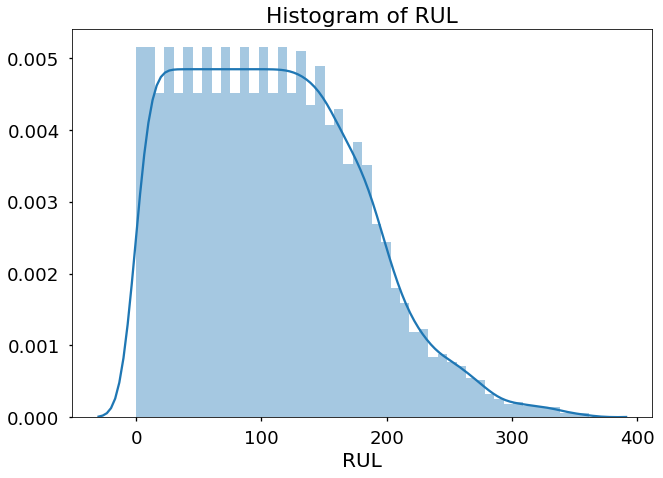

In [5]:
sns.distplot(train_df.RUL)
plt.title('Histogram of RUL')
plt.xlabel('RUL');

## Data Sequencing

In order to fit our data into an Recurrent Neural Network(RNN) setting, we have to turn our data into sequences. First we have to choose the sequence length, which determines how many previous information we want to include in our RNN, which is also the length of RNN. Here we pick sequence length of 5, since it already works well and do not require lots of time to do the inference. Then we generate the sequence of features and labels based on this number. We will split our data into 10% training and 90% validation since the inference step will take a lot of time on large data. Later on we will extend the training-validation ratio to 90:10.

In [6]:
# pick a window size of 5 cycles
sequence_length = 5

In [7]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [8]:
# generator for the sequences
from util import gen_sequence
seq_gen = [list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique()]

In [9]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(seq_gen).astype(np.float32)
seq_array.shape

(20131, 5, 25)

In [10]:
# generate labels
from util import gen_labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.squeeze(np.concatenate(label_gen).astype(np.float32))
label_array.shape

(20131,)

In [11]:
seq_array1,seq_array2,label_array1,label_array2 = train_test_split(seq_array,label_array,test_size=0.9,shuffle=False)

In [12]:
less_50 = label_array2<=50

In [13]:
H = 100  # number of hidden units
N,_,D = seq_array1.shape  # number of training data points, number of features
print(f'Number of hidden units is {H},\nNumber of training data points is {N},\nLength of sequence is {sequence_length},\nNumber of features is {D}')

Number of hidden units is 100,
Number of training data points is 2013,
Length of sequence is 5,
Number of features is 25


# Modeling, Black Box Variational Inference and Critisism

In this part, we will explore different neural network models, each with frequentist(least mean squared error) and Bayesian inference(black box variational inference). We want to make comparisons of the result in two directions: first is the comparison between frequentist and Bayesian inference, and the second is the comparison between different model structures. The comparisons will be based on both theoretical knowledge and model critisism.

## 1.Fully conected layers

First, we will not use RNN structure but fully conected layers to build a baseline model. We want to know that how well the prediction will be if we do not include information from previous cycle. The network contains one hidden layer with hyperbolic tangent activation and output layer with linear activation.  
For the Bayesian inference, we will put normal prior on the weights and biases in the hidden and output layers, and use a normal data likelihood.

In [25]:
model = Sequential()

model.add(Dense(H,
         input_shape=[D],activation='tanh'))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])
model.fit(seq_array1[:,sequence_length-1,:], label_array1, epochs=300, batch_size=200, 
          validation_data=(seq_array2[:,sequence_length-1,:],label_array2), verbose=0);

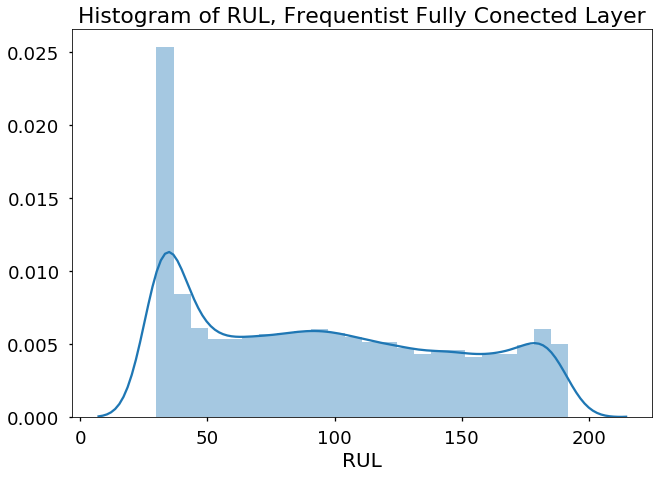

In [26]:
y_pred = np.squeeze(model.predict(seq_array2[:,sequence_length-1,:]))
sns.distplot(y_pred)
plt.title('Histogram of RUL, Frequentist Fully Conected Layer')
plt.xlabel('RUL');

In [27]:
print(f'Validation RMSE: {np.sqrt(mean_squared_error(label_array2,y_pred))}')

Validation RMSE: 42.575931549072266


In [28]:
print(f'Validation RMSE for RUL under 50: {np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50]))}')

Validation RMSE for RUL under 50: 18.658893585205078


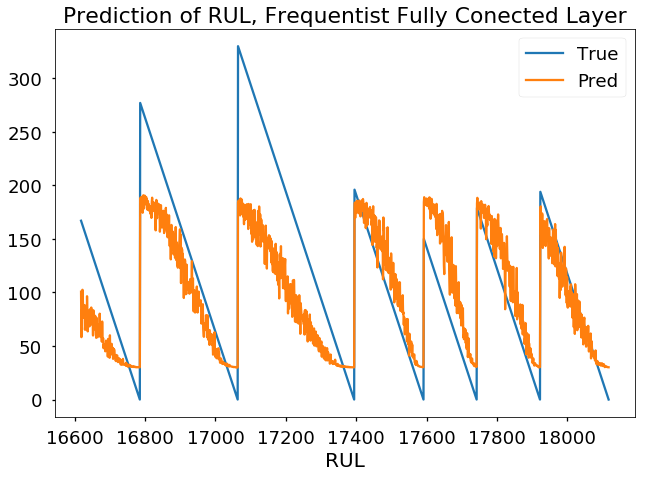

In [29]:
pd.DataFrame([label_array2,y_pred]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Frequentist Fully Conected Layer')
plt.xlabel('RUL');

In [19]:
def neural_network_with_2_layers(x, W_0, W_1, b_0, b_1):
    h = tf.nn.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

W_0 = Normal(loc=tf.zeros([D, H]),
             scale=tf.ones([D, H]))
W_1 = Normal(loc=tf.zeros([H, 1]),
             scale=tf.ones([H, 1]))
b_0 = Normal(loc=tf.zeros(H),
             scale=tf.ones(H))
b_1 = Normal(loc=tf.zeros(1),
             scale=tf.ones(1))

x = tf.placeholder(tf.float32, [N, D])
y = Normal(loc=neural_network_with_2_layers(x, W_0, W_1, b_0, b_1),
           scale=tf.ones(N) * 0.1)  # constant noise

In [20]:
# BACKWARD MODEL A
q_W_0 = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_W_1 = Normal(loc=tf.Variable(tf.random_normal([H, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, 1]))))
q_b_0 = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_b_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [21]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={W_0: q_W_0, b_0: q_b_0,
                                 W_1: q_W_1, b_1: q_b_1},
                    data={x: seq_array1[:,sequence_length-1,:], y: label_array1})
inference.run(n_samples=5,n_iter=25000)

25000/25000 [100%] ██████████████████████████████ Elapsed: 47s | Loss: 58665764.000


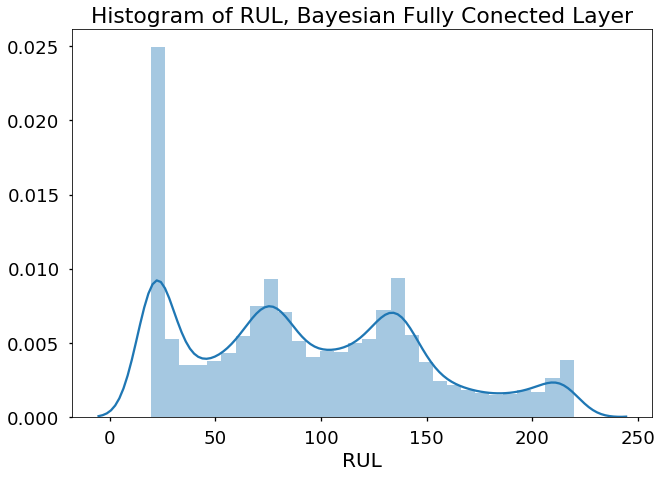

In [22]:
xp = tf.placeholder(tf.float32,seq_array2[:,sequence_length-1,:].shape)
y_preds = [sess.run(neural_network_with_2_layers(xp,q_W_0, q_W_1,q_b_0, q_b_1),{xp:seq_array2[:,sequence_length-1,:]})
          for _ in range(50)]
sns.distplot(y_preds[0])
plt.title('Histogram of RUL, Bayesian Fully Conected Layer')
plt.xlabel('RUL');

In [23]:
print(f'Average Validation RMSE: {np.mean([np.sqrt(mean_squared_error(label_array2,y_pred)) for y_pred in y_preds])}')

Average Validation RMSE: 42.810935974121094


In [24]:
print(f'Average Validation RMSE for RUL under 50: {np.mean([np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50])) for y_pred in y_preds])}')

Average Validation RMSE for RUL under 50: 15.082162857055664


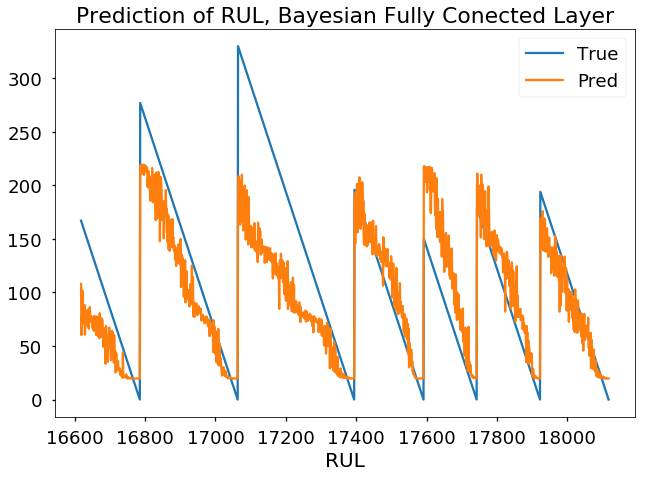

In [25]:
pd.DataFrame([label_array2,y_preds[0]]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Bayesian Fully Conected Layer')
plt.xlabel('RUL');

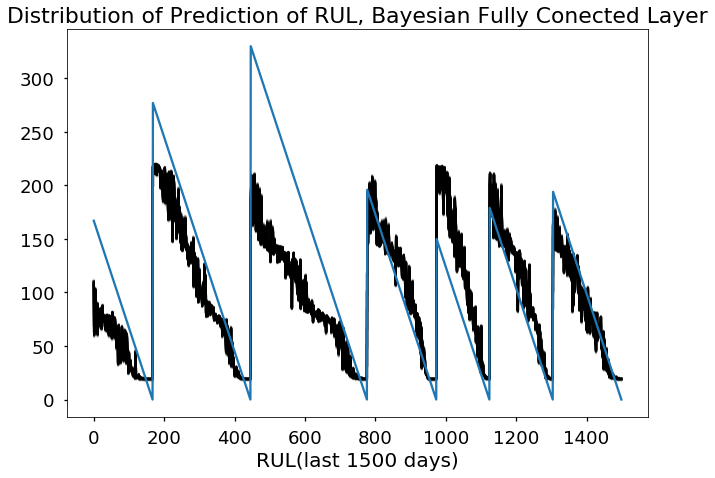

In [26]:
[plt.plot(y_pred[-1500:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-1500:])
plt.title('Distribution of Prediction of RUL, Bayesian Fully Conected Layer')
plt.xlabel('RUL(last 1500 days)');

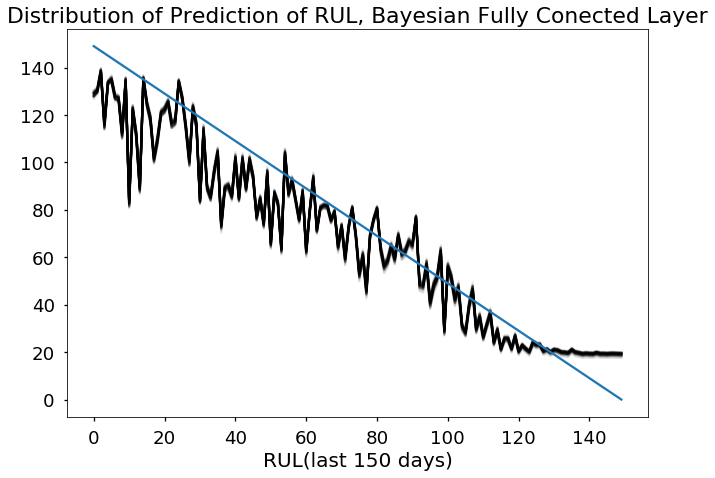

In [27]:
[plt.plot(y_pred[-150:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-150:])
plt.title('Distribution of Prediction of RUL, Bayesian Fully Conected Layer')
plt.xlabel('RUL(last 150 days)');

**First**, we can see that RMSE can not truely represent the goodness of fit in this setting. The frequentist and Bayesian inference has very similar RMSE, but the visualization shows Bayesian inference gets much better results than frequentist. So in the later model critisism we will mainly focus on the visualization.  
**Second**, because of the nature of this data set, it may be harder to predict large RUL than small RUL. For example, turbofan at 200 cycle before breakdown may have very similar feature set values with turbofan at 150 cycle because it has not yet started degradation, but feature set at cycle 50 may be very different with that at cycle 1. In addition, we care more about the smaller values of RUL. It does not matter so much it is 200 days or 150 days until the turbofan breaks down, but it matters very much if the RUL is small because this is time we want to send technician to fix the turbofan. So we will think models that performs well in the smaller range of RUL is better. Clearly both of the models are not good, the Bayesian approach one is slightly better.  
**Third**, the purpose of using Bayesian inference is to get a distribution at each prediction point, in order to get the confidence level. We expect the point that are not accurately predicted will have higher variance. However, in this model, this is not the case.  
**Forth**, the convergence of Bayesian inference seems much more robust than frequentist inference. The frequentist inference converge to the above result 2 in 5 times, but the Bayesian inference will almost always converge to the above result.

## 2.Simple RNN

Next, we will use RNN structures as out models. First is the simple RNN, the structure is as follows:
![A recurrent neural network and the unfolding in time of the computation involved in its forward computation. Source: Nature
](pics/rnn.jpg)
Simple RNN is good at remembering previous information. It will integrate data from previous period into its hidden state, and propagate the hidden state to the next period. We will also use hyperbolic tangent activation in the hidden layer.  
For the Bayesian inference, we will put normal prior on the weights and biases in the hidden and output layers, and use a normal data likelihood.

In [28]:
model = Sequential()

model.add(SimpleRNN(
         input_shape=(sequence_length, D),
         units=H))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])
model.fit(seq_array1, label_array1, epochs=300, batch_size=200, 
          validation_data=(seq_array2,label_array2), verbose=0);

Instructions for updating:
keep_dims is deprecated, use keepdims instead


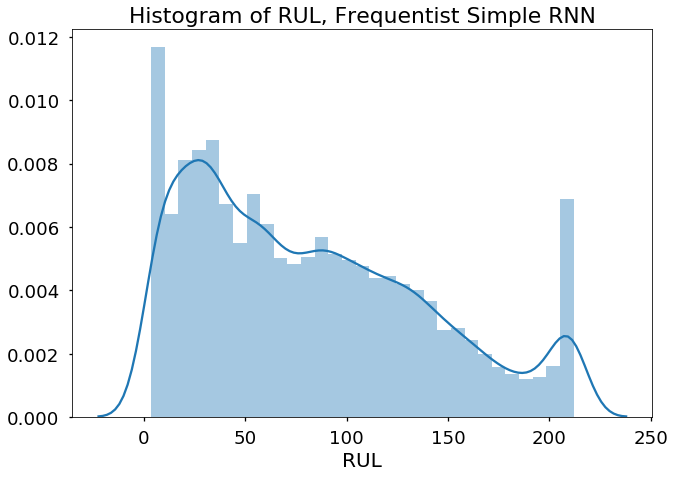

In [29]:
y_pred = np.squeeze(model.predict(seq_array2))
sns.distplot(y_pred)
plt.title('Histogram of RUL, Frequentist Simple RNN')
plt.xlabel('RUL');

In [30]:
print(f'Validation RMSE: {np.sqrt(mean_squared_error(label_array2,y_pred))}')

Validation RMSE: 47.97038269042969


In [31]:
print(f'Validation RMSE for RUL under 50: {np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50]))}')

Validation RMSE for RUL under 50: 10.702292442321777


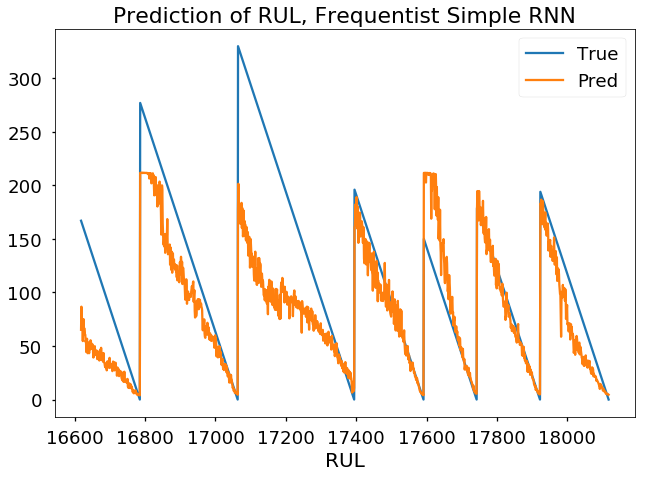

In [32]:
pd.DataFrame([label_array2,y_pred]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Frequentist Simple RNN')
plt.xlabel('RUL');

In [16]:
def rnn_cell_sig(hprev, xt, Wh, Wx, bh):
    return tf.sigmoid(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

def rnn_cell_tanh(hprev, xt, Wh, Wx, bh):
    return tf.tanh(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

In [34]:
def rnn_layer(X, Wh, Wx, bh, Wy, by, H):
    N, sequence_length, D = X.get_shape().as_list()
    h = tf.zeros([N,H])
    for i in range(sequence_length):
        h = rnn_cell_tanh(h,tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wh, Wx, bh)
    return tf.reshape(tf.matmul(h, Wy) + by,[-1])

# def rnn_cell(hprev, xt):
#     return tf.tanh(tf.matmul(hprev, Wh) + tf.matmul(xt, Wx) + bh)

# def rnn_layer(X, Wh, Wx, bh, Wy, by, H):
#     sequence_length, N, D = X.get_shape().as_list()
#     h = tf.scan(rnn_cell, X, initializer=tf.truncated_normal([N,H],mean=0.,stddev=0.1))
#     h = tf.squeeze(tf.slice(h,[sequence_length-1,0,0],[1,N,H]))
#     y = tf.reshape(tf.nn.softplus(tf.matmul(h, Wy) + by),[-1])
#     return y

Wh = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Wx = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wy = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))
bh = Normal(loc=tf.zeros(H), scale=tf.ones(H))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
# X = tf.placeholder(tf.float32,[sequence_length,N,D])
y = Normal(loc=rnn_layer(X, Wh, Wx, bh, Wy, by, H), scale=1.)

## BBVI

In [35]:
# BACKWARD MODEL A
q_Wh = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Wx = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wy = Normal(loc=tf.Variable(tf.random_normal([H, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, 1]))))
q_bh = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [36]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wh: q_Wh, bh: q_bh,
                                 Wx: q_Wx, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 146s | Loss: 567084.125


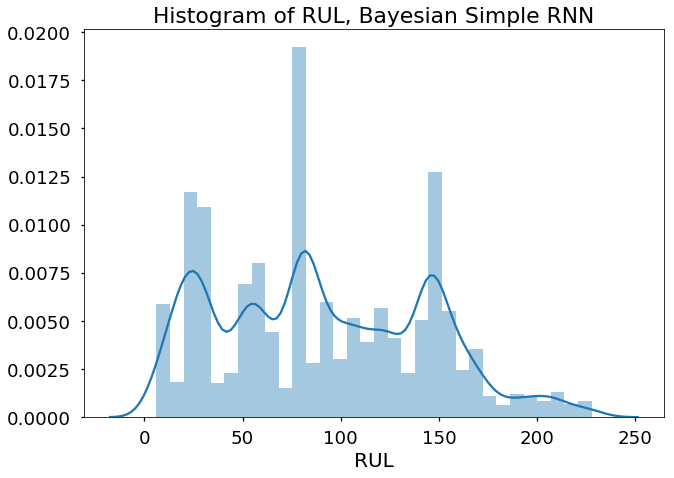

In [37]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_preds = [sess.run(rnn_layer(Xp, q_Wh, q_Wx, q_bh, q_Wy, q_by, H),{Xp:seq_array2})
          for _ in range(50)]
sns.distplot(y_preds[0])
plt.title('Histogram of RUL, Bayesian Simple RNN')
plt.xlabel('RUL');

In [38]:
print(f'Average Validation RMSE: {np.mean([np.sqrt(mean_squared_error(label_array2,y_pred)) for y_pred in y_preds])}')

Average Validation RMSE: 43.368690490722656


In [39]:
print(f'Average Validation RMSE for RUL under 50: {np.mean([np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50])) for y_pred in y_preds])}')

Average Validation RMSE for RUL under 50: 13.645428657531738


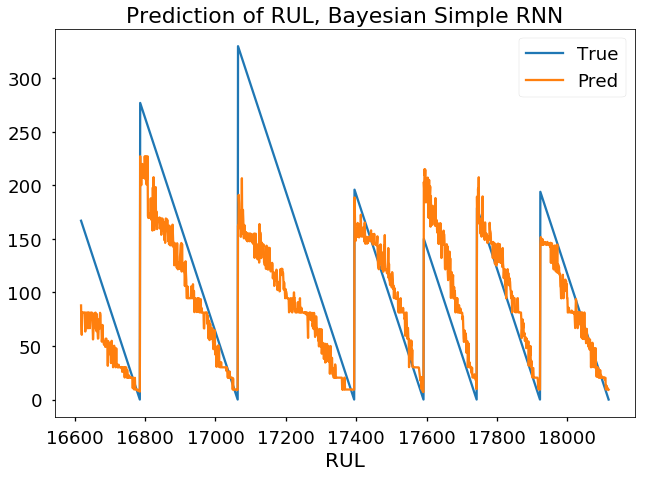

In [40]:
pd.DataFrame([label_array2,y_preds[0]]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Bayesian Simple RNN')
plt.xlabel('RUL');

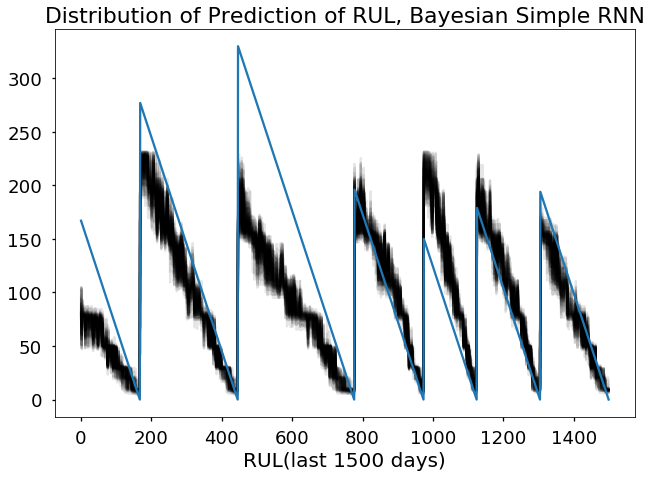

In [41]:
[plt.plot(y_pred[-1500:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-1500:])
plt.title('Distribution of Prediction of RUL, Bayesian Simple RNN')
plt.xlabel('RUL(last 1500 days)');

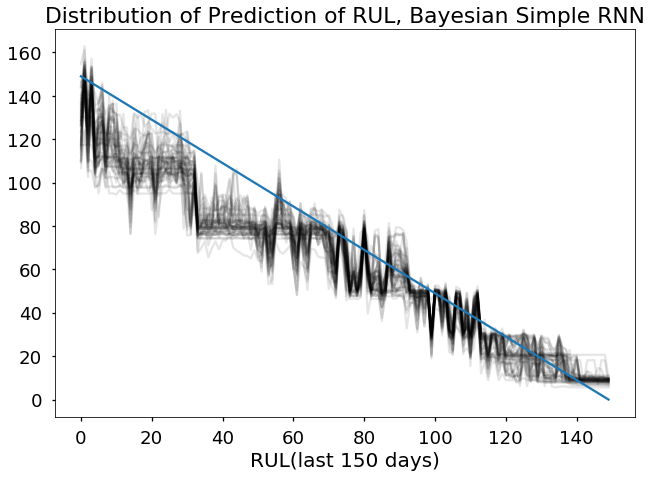

In [42]:
[plt.plot(y_pred[-150:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-150:])
plt.title('Distribution of Prediction of RUL, Bayesian Simple RNN')
plt.xlabel('RUL(last 150 days)');

We can see that both frequentist and Bayesian inference yield better prediction than fully connected layer from the plot, although the RMSE is still quite similar. The prediction is especially better for the smaller values of RUL, which is desired. However, the predition is very noisy, and the posterior has a relatively high variance.  
A very interesting phenomenon is that for those points which are not accurately predicted, the posterior prediction variance is also very high. So we can successfully get a correct confidence level of prediction from our posterior prediction distribution, which is the original purpose to use Bayesian neural networks.  
**TODO:Mode collapse**

## 3. LSTM

An Long short-term memory(LSTM) network contains a (memory) cell and three gates that control or regulate information flow: an input gate, an output gate and a forget gate. These gates compute an activation often using the logistic function. These gates can be thought as conventional artificial neurons. The cell "remembers" a value for either long or short time periods. The input gate controls the extent to which a new value flows into the memory, the forget gate controls the extent to which a value remains in memory and the output gate controls the extent to which the value in memory is used to compute the output activation of the LSTM block.  
![LSTM Gating. Chung, Junyoung, et al. “Empirical evaluation of gated recurrent neural networks on sequence modeling.” (2014)](pics/LSTM.png)
We will put normal prior on the weights and biases for the cell, three gates and the output layer, and use normal likelihood.

In [43]:
model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, D),
         units=H))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])
model.fit(seq_array1, label_array1, epochs=300, batch_size=200, 
          validation_data=(seq_array2,label_array2), verbose=0);

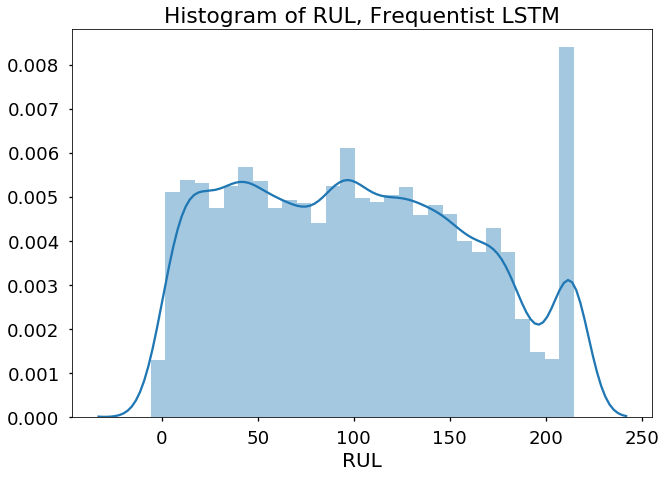

In [44]:
y_pred = np.squeeze(model.predict(seq_array2))
sns.distplot(y_pred)
plt.title('Histogram of RUL, Frequentist LSTM')
plt.xlabel('RUL');

In [45]:
print(f'Validation RMSE: {np.sqrt(mean_squared_error(label_array2,y_pred))}')

Validation RMSE: 41.26831817626953


In [46]:
print(f'Validation RMSE for RUL under 50: {np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50]))}')

Validation RMSE for RUL under 50: 12.511690139770508


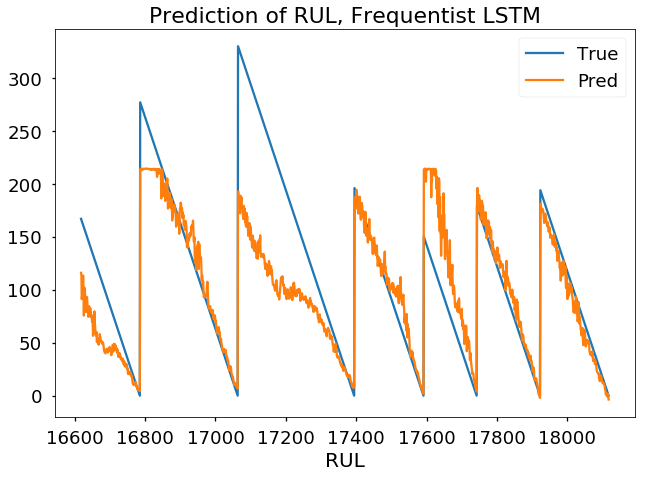

In [47]:
pd.DataFrame([label_array2,y_pred]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Frequentist LSTM')
plt.xlabel('RUL');

In [17]:
def LSTM_cell(hprev, cprev, xt, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc):
    f = rnn_cell_sig(hprev,xt,Wf,Uf,bf)
    i = rnn_cell_sig(hprev,xt,Wi,Ui,bi)
    o = rnn_cell_sig(hprev,xt,Wo,Uo,bo)
    c = f*cprev + i*rnn_cell_tanh(hprev,xt,Wc,Uc,bc)
    h = o*tf.tanh(c)
    return h,c

def LSTM_layer(X, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc, Wy, by, H):
    N, sequence_length, D = X.get_shape().as_list()
    h = tf.zeros([N,H])
    c = tf.zeros([N,H])
    for i in range(sequence_length):
        h,c = LSTM_cell(h, c, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc)
    return tf.reshape(tf.matmul(h, Wy) + by,[-1])


Wf = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uf = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wi = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Ui = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wo = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uo = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wc = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uc = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wy = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))
bf = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bi = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bo = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bc = Normal(loc=tf.zeros(H), scale=tf.ones(H))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=LSTM_layer(X, Wf, Uf, Wi, Ui, Wo, Uo, Wc, Uc, bf, bi, bo, bc, Wy, by, H), scale=1.)

## BBVI

In [18]:
# BACKWARD MODEL A
q_Wf = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uf = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wi = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Ui = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wo = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uo = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wc = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uc = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wy = Normal(loc=tf.Variable(tf.random_normal([H, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, 1]))))
q_bf = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bi = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bo = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bc = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [19]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wf: q_Wf, Uf: q_Uf, Wi: q_Wi, Ui: q_Ui, Wo: q_Wo, Uo: q_Uo, Wc: q_Wc, Uc: q_Uc,
                                 bf: q_bf, bi: q_bi, bo: q_bo, bc: q_bc, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 601s | Loss: 126271.578


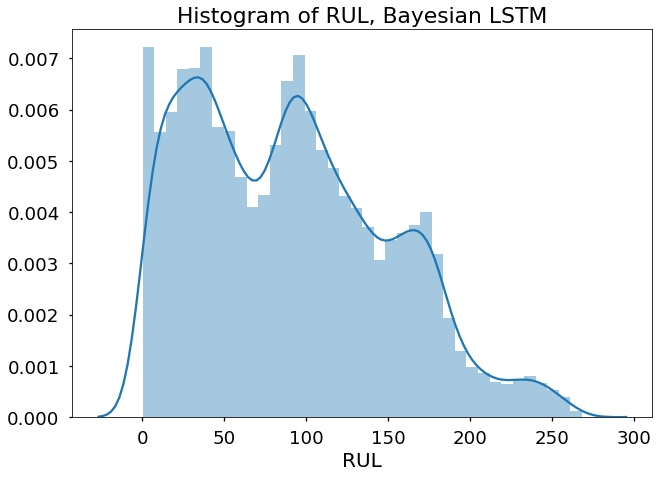

In [51]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_preds = [sess.run(LSTM_layer(Xp, q_Wf, q_Uf, q_Wi, q_Ui, q_Wo, q_Uo, q_Wc, q_Uc, 
                             q_bf, q_bi, q_bo, q_bc, q_Wy, q_by, H),{Xp:seq_array2})
          for _ in range(50)]
sns.distplot(y_preds[0])
plt.title('Histogram of RUL, Bayesian LSTM')
plt.xlabel('RUL');

In [52]:
print(f'Average Validation RMSE: {np.mean([np.sqrt(mean_squared_error(label_array2,y_pred)) for y_pred in y_preds])}')

Average Validation RMSE: 45.12302780151367


In [53]:
print(f'Average Validation RMSE for RUL under 50: {np.mean([np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50])) for y_pred in y_preds])}')

Average Validation RMSE for RUL under 50: 10.24901008605957


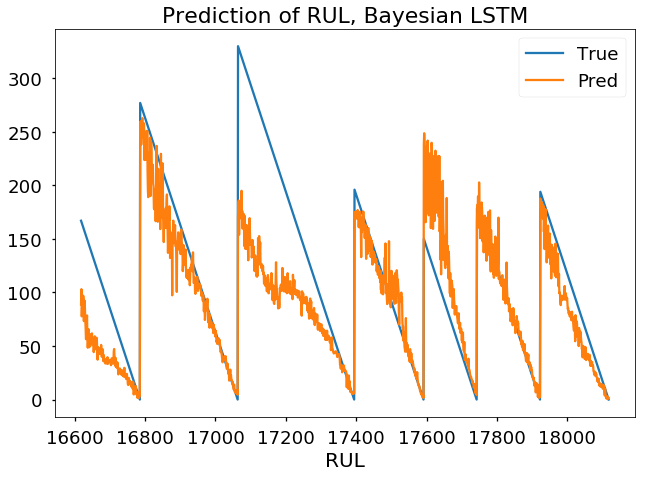

In [54]:
pd.DataFrame([label_array2,y_preds[0]]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Bayesian LSTM')
plt.xlabel('RUL');

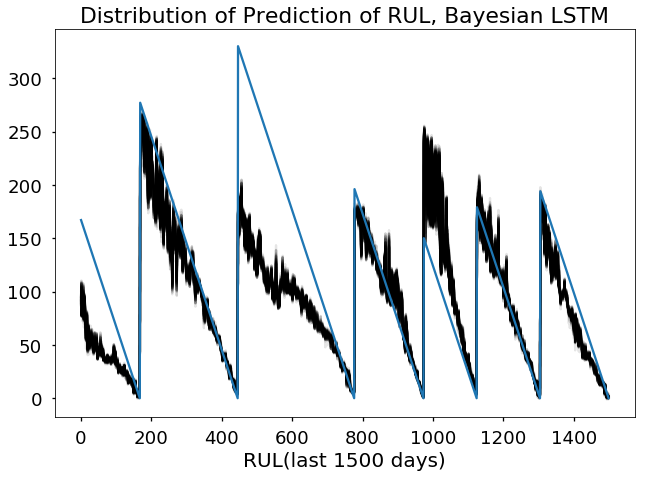

In [55]:
[plt.plot(y_pred[-1500:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-1500:])
plt.title('Distribution of Prediction of RUL, Bayesian LSTM')
plt.xlabel('RUL(last 1500 days)');

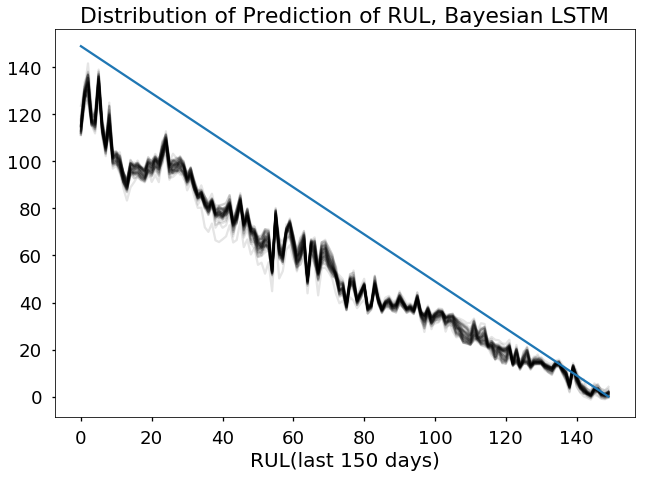

In [56]:
[plt.plot(y_pred[-150:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-150:])
plt.title('Distribution of Prediction of RUL, Bayesian LSTM')
plt.xlabel('RUL(last 150 days)');

## 4.GRU

Gated recurrent unit (GRU) is a gating mechanism that is similar to that of long short-term memory. They have fewer parameters than LSTM, as they lack the cell and the output gate, but they have similar performance in many cases.  
![GRU Gating. Chung, Junyoung, et al. “Empirical evaluation of gated recurrent neural networks on sequence modeling.” (2014)
](pics/GRU.png)
We will put normal prior on the weights and biases for the update gate, reset gate and the output layer, and use normal likelihood.

In [57]:
model = Sequential()

model.add(GRU(
         input_shape=(sequence_length, D),
         units=H))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])
model.fit(seq_array1, label_array1, epochs=300, batch_size=200, 
          validation_data=(seq_array2,label_array2), verbose=0);

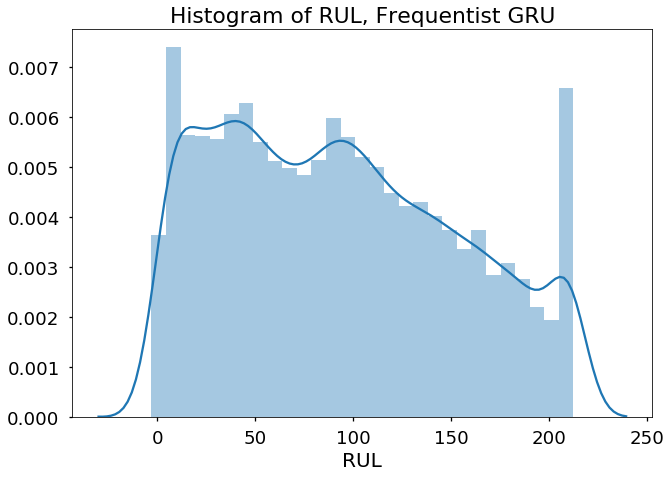

In [58]:
y_pred = np.squeeze(model.predict(seq_array2))
sns.distplot(y_pred)
plt.title('Histogram of RUL, Frequentist GRU')
plt.xlabel('RUL');

In [59]:
print(f'Validation RMSE: {np.sqrt(mean_squared_error(label_array2,y_pred))}')

Validation RMSE: 42.57139587402344


In [60]:
print(f'Validation RMSE for RUL under 50: {np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50]))}')

Validation RMSE for RUL under 50: 11.344544410705566


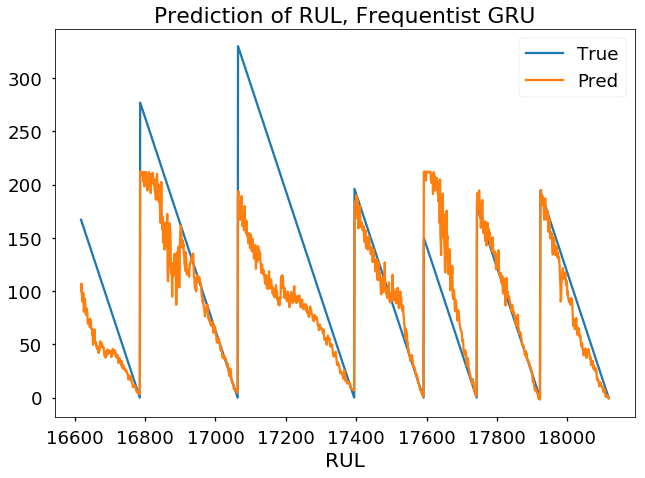

In [61]:
pd.DataFrame([label_array2,y_pred]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Frequentist GRU')
plt.xlabel('RUL');

In [62]:
def GRU_cell(hprev, xt, Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh):
    z = rnn_cell_sig(hprev,xt,Wz,Uz,bz)
    r = rnn_cell_sig(hprev,xt,Wr,Ur,br)
    h = z*hprev + (1-z)*rnn_cell_tanh(r*hprev,xt,Wh,Uh,bh)
    return h

def GRU_layer(X, Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh, Wy, by, H):
    N, sequence_length, D = X.get_shape().as_list()
    h = tf.zeros([N,H])
    for i in range(sequence_length):
        h = GRU_cell(h, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh)
    return tf.reshape(tf.matmul(h, Wy) + by,[-1])


Wz = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uz = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wr = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Ur = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wh = Normal(loc=tf.zeros([H, H]), scale=tf.ones([H, H]))
Uh = Normal(loc=tf.zeros([D, H]), scale=tf.ones([D, H]))
Wy = Normal(loc=tf.zeros([H, 1]), scale=tf.ones([H, 1]))
bz = Normal(loc=tf.zeros(H), scale=tf.ones(H))
br = Normal(loc=tf.zeros(H), scale=tf.ones(H))
bh = Normal(loc=tf.zeros(H), scale=tf.ones(H))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=GRU_layer(X, Wz, Uz, Wr, Ur, Wh, Uh, bz, br, bh, Wy, by, H), scale=1.)

## BBVI

In [63]:
# BACKWARD MODEL A
q_Wz = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uz = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wr = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Ur = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wh = Normal(loc=tf.Variable(tf.random_normal([H, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, H]))))
q_Uh = Normal(loc=tf.Variable(tf.random_normal([D, H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H]))))
q_Wy = Normal(loc=tf.Variable(tf.random_normal([H, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H, 1]))))
q_bz = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_br = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_bh = Normal(loc=tf.Variable(tf.random_normal([H])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [64]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wz: q_Wz, Uz: q_Uz, Wr: q_Wr, Ur: q_Ur, Wh: q_Wh, Uh: q_Uh,
                                 bz: q_bz, bz: q_bz, bh: q_bh, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 481s | Loss: 269874.156


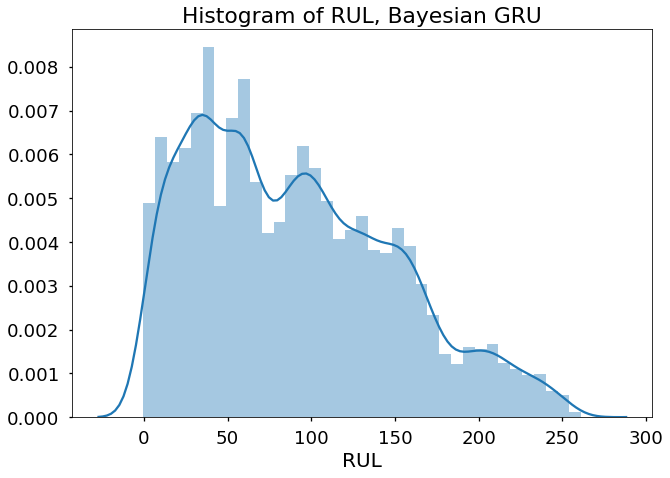

In [65]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_preds = [sess.run(GRU_layer(Xp, q_Wz, q_Uz, q_Wr, q_Ur, q_Wh, q_Uh, 
                            q_bz, q_br, q_bh, q_Wy, q_by, H),{Xp:seq_array2})
          for _ in range(50)]
sns.distplot(y_preds[0])
plt.title('Histogram of RUL, Bayesian GRU')
plt.xlabel('RUL');

In [66]:
print(f'Average Validation RMSE: {np.mean([np.sqrt(mean_squared_error(label_array2,y_pred)) for y_pred in y_preds])}')

Average Validation RMSE: 45.09455490112305


In [67]:
print(f'Average Validation RMSE for RUL under 50: {np.mean([np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50])) for y_pred in y_preds])}')

Average Validation RMSE for RUL under 50: 10.442204475402832


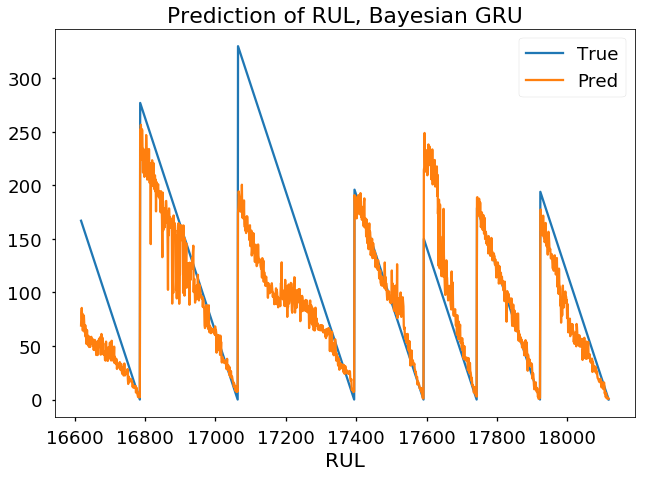

In [68]:
pd.DataFrame([label_array2,y_preds[0]]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Bayesian GRU')
plt.xlabel('RUL');

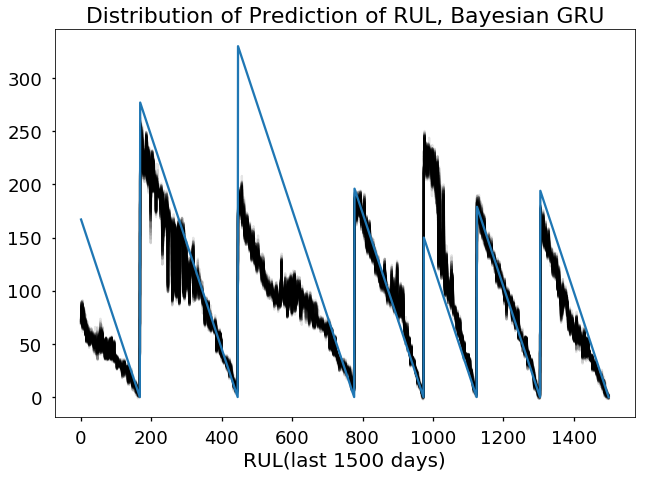

In [69]:
[plt.plot(y_pred[-1500:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-1500:])
plt.title('Distribution of Prediction of RUL, Bayesian GRU')
plt.xlabel('RUL(last 1500 days)');

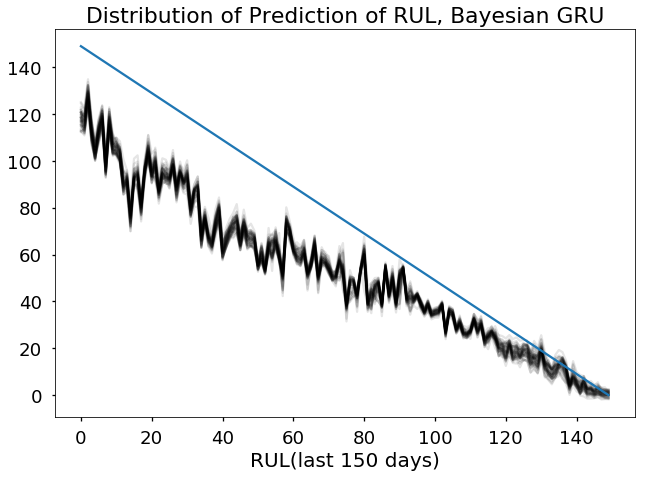

In [70]:
[plt.plot(y_pred[-150:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-150:])
plt.title('Distribution of Prediction of RUL, Bayesian GRU')
plt.xlabel('RUL(last 150 days)');

## 5.Two layer Simple RNN

In [71]:
H1=100
H2=50

model = Sequential()

model.add(SimpleRNN(
         input_shape=(sequence_length, D),
         units=H1,return_sequences=True))

model.add(SimpleRNN(
         units=H2))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])
model.fit(seq_array1, label_array1, epochs=300, batch_size=200, 
          validation_data=(seq_array2,label_array2), verbose=0);

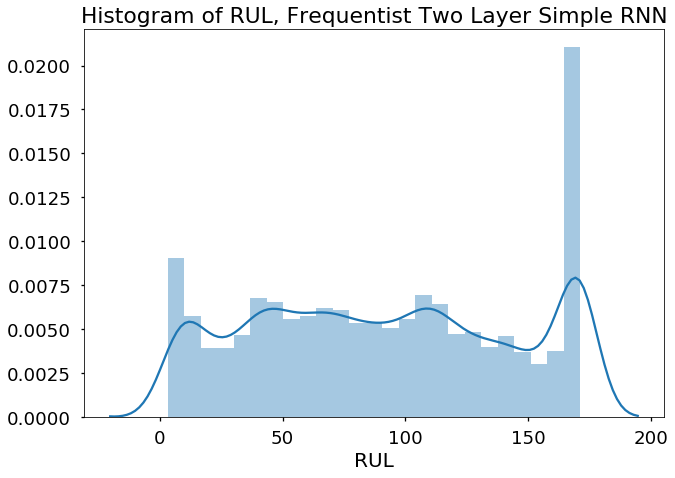

In [72]:
y_pred = np.squeeze(model.predict(seq_array2))
sns.distplot(y_pred)
plt.title('Histogram of RUL, Frequentist Two Layer Simple RNN')
plt.xlabel('RUL');

In [73]:
print(f'Validation RMSE: {np.sqrt(mean_squared_error(label_array2,y_pred))}')

Validation RMSE: 43.1196174621582


In [74]:
print(f'Validation RMSE for RUL under 50: {np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50]))}')

Validation RMSE for RUL under 50: 12.64370059967041


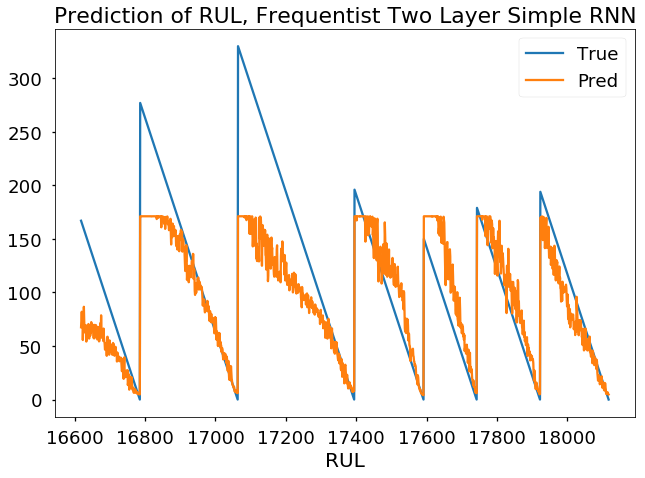

In [75]:
pd.DataFrame([label_array2,y_pred]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Frequentist Two Layer Simple RNN')
plt.xlabel('RUL');

In [76]:
def two_rnn_layer(X, Wh1, Wx1, bh1, Wh2, Wx2, bh2, Wy, by, H1, H2):
    N, sequence_length, D = X.get_shape().as_list()
    h1 = tf.zeros([N,H1])
    h2 = tf.zeros([N,H2])
    for i in range(sequence_length):
        h1 = rnn_cell_tanh(h1, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wh1, Wx1, bh1)
        h2 = rnn_cell_tanh(h2, h1, Wh2, Wx2, bh2)
    return tf.reshape(tf.matmul(h2, Wy) + by,[-1])

Wh1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Wx1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))
Wh2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Wx2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))
Wy = Normal(loc=tf.zeros([H2, 1]), scale=tf.ones([H2, 1]))
bh1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bh2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=two_rnn_layer(X, Wh1, Wx1, bh1, Wh2, Wx2, bh2, Wy, by, H1, H2), scale=1.)

In [77]:
# BACKWARD MODEL A
q_Wh1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Wx1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))
q_Wh2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Wx2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))
q_Wy = Normal(loc=tf.Variable(tf.random_normal([H2, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, 1]))))
q_bh1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bh2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [78]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wh1: q_Wh1, bh1: q_bh1, Wh2: q_Wh2, bh2: q_bh2,
                                 Wx1: q_Wx1, Wx2: q_Wx2, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 258s | Loss: 1373215.000


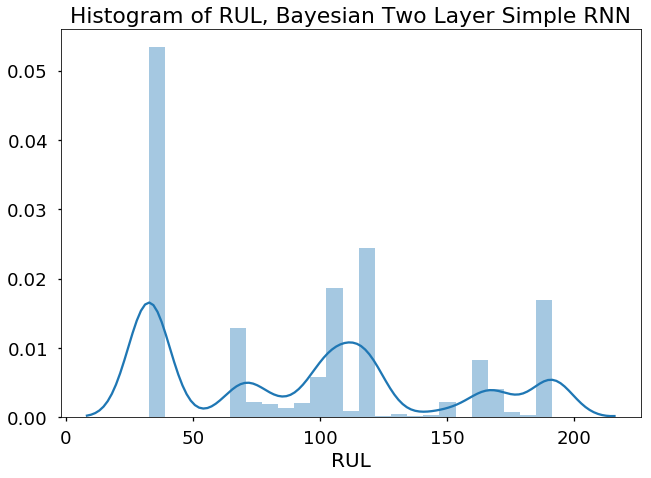

In [79]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_preds = [sess.run(two_rnn_layer(Xp, q_Wh1, q_Wx1, q_bh1, q_Wh2, q_Wx2, q_bh2, q_Wy, q_by, H1, H2),{Xp:seq_array2})
          for _ in range(50)]
sns.distplot(y_preds[0])
plt.title('Histogram of RUL, Bayesian Two Layer Simple RNN')
plt.xlabel('RUL');

In [80]:
print(f'Average Validation RMSE: {np.mean([np.sqrt(mean_squared_error(label_array2,y_pred)) for y_pred in y_preds])}')

Average Validation RMSE: 47.8739128112793


In [81]:
print(f'Average Validation RMSE for RUL under 50: {np.mean([np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50])) for y_pred in y_preds])}')

Average Validation RMSE for RUL under 50: 21.787691116333008


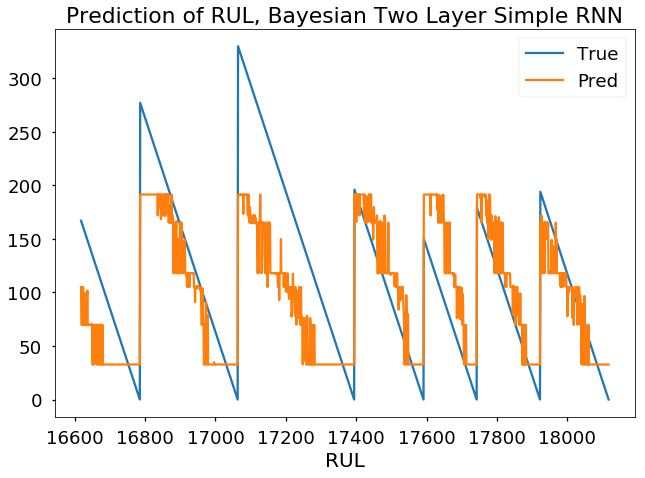

In [82]:
pd.DataFrame([label_array2,y_preds[0]]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Bayesian Two Layer Simple RNN')
plt.xlabel('RUL');

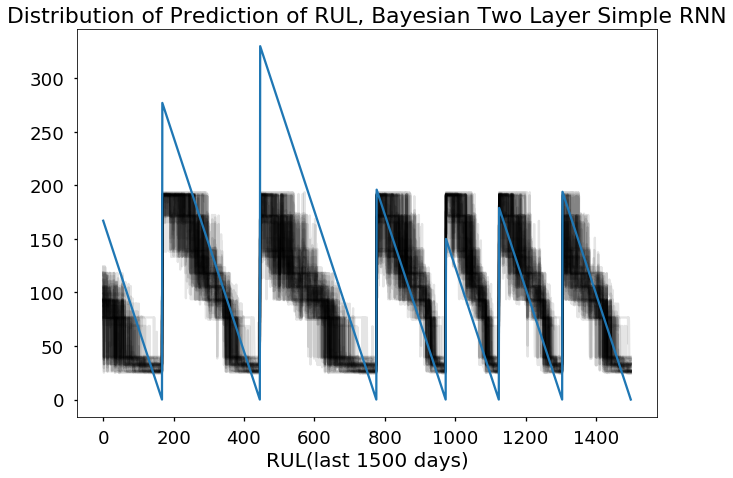

In [83]:
[plt.plot(y_pred[-1500:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-1500:])
plt.title('Distribution of Prediction of RUL, Bayesian Two Layer Simple RNN')
plt.xlabel('RUL(last 1500 days)');

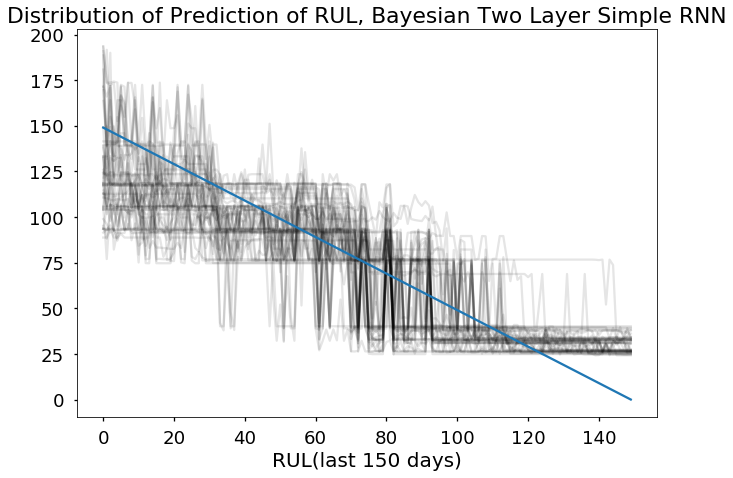

In [84]:
[plt.plot(y_pred[-150:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-150:])
plt.title('Distribution of Prediction of RUL, Bayesian Two Layer Simple RNN')
plt.xlabel('RUL(last 150 days)');

## 6.Two layer LSTM

In [14]:
H1=100
H2=50

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, D),
         units=H1,return_sequences=True))

model.add(LSTM(
         units=H2))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])
model.fit(seq_array1, label_array1, epochs=300, batch_size=200, 
          validation_data=(seq_array2,label_array2), verbose=0);

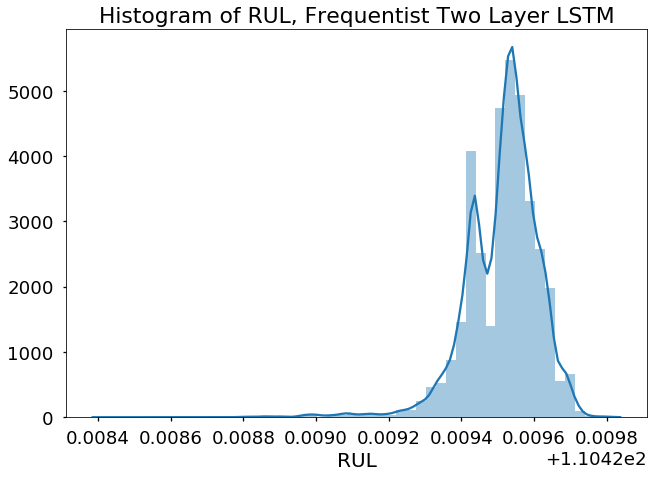

In [15]:
y_pred = np.squeeze(model.predict(seq_array2))
sns.distplot(y_pred)
plt.title('Histogram of RUL, Frequentist Two Layer LSTM')
plt.xlabel('RUL');

In [16]:
print(f'Validation RMSE: {np.sqrt(mean_squared_error(label_array2,y_pred))}')

Validation RMSE: 67.92393493652344


In [17]:
print(f'Validation RMSE for RUL under 50: {np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50]))}')

Validation RMSE for RUL under 50: 86.6883773803711


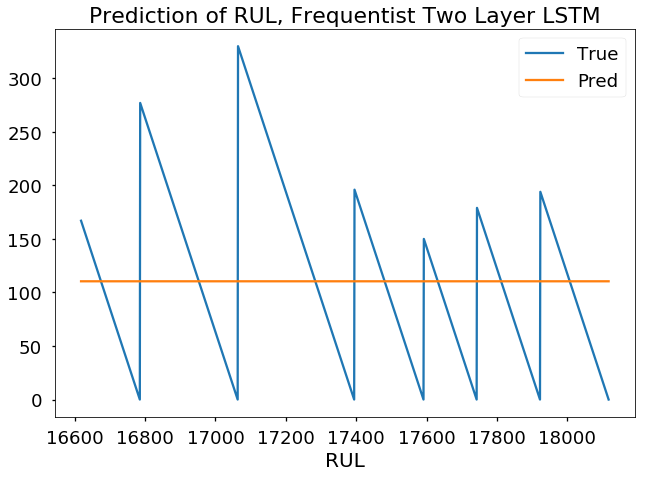

In [18]:
pd.DataFrame([label_array2,y_pred]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Frequentist Two Layer LSTM')
plt.xlabel('RUL');

In [90]:
def two_LSTM_layer(X, Wf1, Uf1, Wi1, Ui1, Wo1, Uo1, Wc1, Uc1, bf1, bi1, bo1, bc1, 
               Wf2, Uf2, Wi2, Ui2, Wo2, Uo2, Wc2, Uc2, bf2, bi2, bo2, bc2, Wy, by, H1, H2):
    N, sequence_length, D = X.get_shape().as_list()
    h1 = tf.zeros([N,H1])
    c1 = tf.zeros([N,H1])
    h2 = tf.zeros([N,H2])
    c2 = tf.zeros([N,H2])
    for i in range(sequence_length):
        h1,c1 = LSTM_cell(h1, c1, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), 
                          Wf1, Uf1, Wi1, Ui1, Wo1, Uo1, Wc1, Uc1, bf1, bi1, bo1, bc1)
        h2,c2 = LSTM_cell(h2, c2, h1, 
                          Wf2, Uf2, Wi2, Ui2, Wo2, Uo2, Wc2, Uc2, bf2, bi2, bo2, bc2)
        
    return tf.reshape(tf.matmul(h2, Wy) + by,[-1])


Wf1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Uf1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))
Wi1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Ui1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))
Wo1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Uo1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))
Wc1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Uc1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))

Wf2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Uf2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))
Wi2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Ui2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))
Wo2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Uo2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))
Wc2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Uc2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))

Wy = Normal(loc=tf.zeros([H2, 1]), scale=tf.ones([H2, 1]))
bf1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bi1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bo1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bc1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bf2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
bi2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
bo2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
bc2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=two_LSTM_layer(X, Wf1, Uf1, Wi1, Ui1, Wo1, Uo1, Wc1, Uc1, bf1, bi1, bo1, bc1, 
               Wf2, Uf2, Wi2, Ui2, Wo2, Uo2, Wc2, Uc2, bf2, bi2, bo2, bc2, Wy, by, H1, H2), scale=1.)

In [91]:
# BACKWARD MODEL A
q_Wf1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Uf1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))
q_Wi1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Ui1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))
q_Wo1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Uo1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))
q_Wc1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Uc1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))

q_Wf2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Uf2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))
q_Wi2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Ui2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))
q_Wo2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Uo2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))
q_Wc2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Uc2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))

q_Wy = Normal(loc=tf.Variable(tf.random_normal([H2, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, 1]))))
q_bf1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bi1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bo1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bc1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bf2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_bi2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_bo2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_bc2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [92]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wf1: q_Wf1, Uf1: q_Uf1, Wi1: q_Wi1, Ui1: q_Ui1, 
                                 Wo1: q_Wo1, Uo1: q_Uo1, Wc1: q_Wc1, Uc1: q_Uc1,
                                 Wf2: q_Wf2, Uf2: q_Uf2, Wi2: q_Wi2, Ui2: q_Ui2, 
                                 Wo2: q_Wo2, Uo2: q_Uo2, Wc2: q_Wc2, Uc2: q_Uc2,
                                 bf1: q_bf1, bi1: q_bi1, bo1: q_bo1, bc1: q_bc1, 
                                 bf2: q_bf2, bi2: q_bi2, bo2: q_bo2, bc2: q_bc2,
                                 Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 1197s | Loss: 141815.750


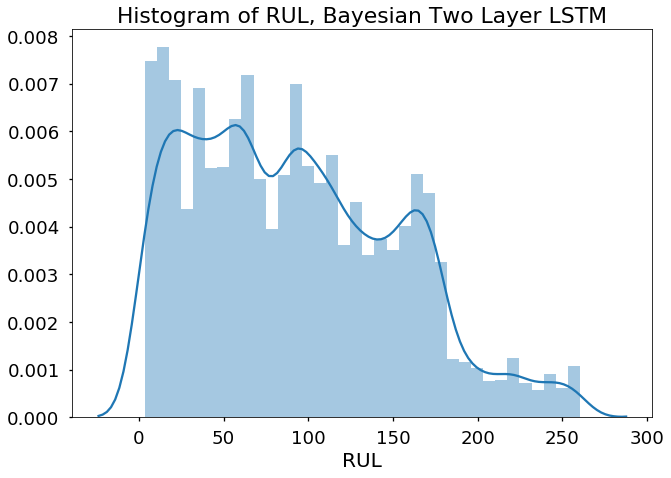

In [93]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_preds = [sess.run(two_LSTM_layer(Xp, q_Wf1, q_Uf1, q_Wi1, q_Ui1, q_Wo1, q_Uo1, q_Wc1, q_Uc1, q_bf1, q_bi1, q_bo1, q_bc1, 
               q_Wf2, q_Uf2, q_Wi2, q_Ui2, q_Wo2, q_Uo2, q_Wc2, q_Uc2, q_bf2, q_bi2, q_bo2, q_bc2, q_Wy, q_by, H1, H2),
                    {Xp:seq_array2})
          for _ in range(50)]
sns.distplot(y_preds[0])
plt.title('Histogram of RUL, Bayesian Two Layer LSTM')
plt.xlabel('RUL');

In [94]:
print(f'Average Validation RMSE: {np.mean([np.sqrt(mean_squared_error(label_array2,y_pred)) for y_pred in y_preds])}')

Average Validation RMSE: 44.39517593383789


In [95]:
print(f'Average Validation RMSE for RUL under 50: {np.mean([np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50])) for y_pred in y_preds])}')

Average Validation RMSE for RUL under 50: 10.529784202575684


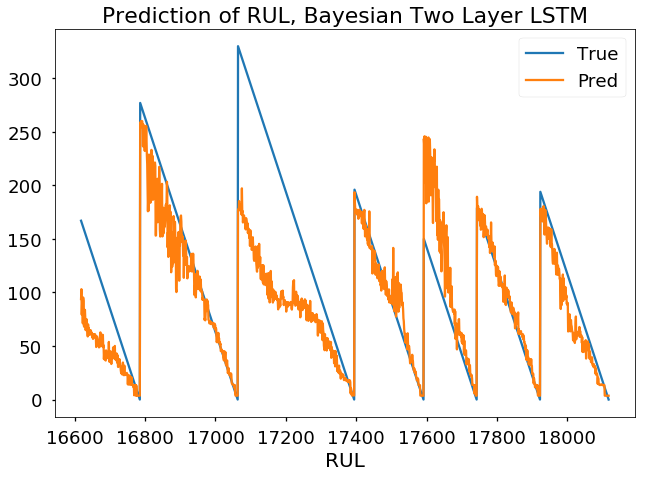

In [96]:
pd.DataFrame([label_array2,y_preds[0]]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Bayesian Two Layer LSTM')
plt.xlabel('RUL');

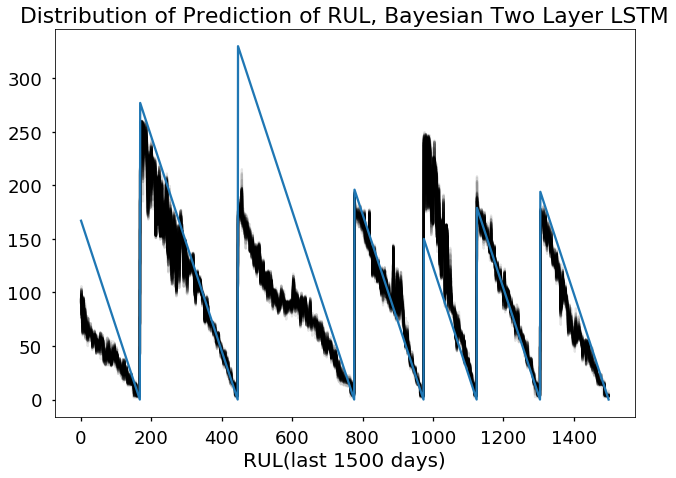

In [97]:
[plt.plot(y_pred[-1500:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-1500:])
plt.title('Distribution of Prediction of RUL, Bayesian Two Layer LSTM')
plt.xlabel('RUL(last 1500 days)');

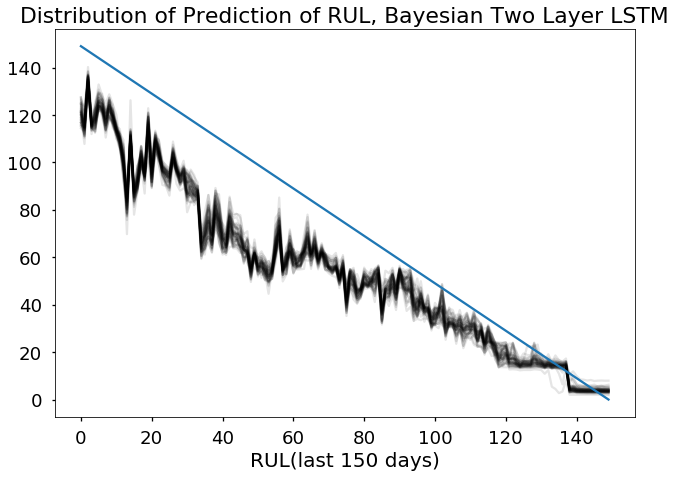

In [98]:
[plt.plot(y_pred[-150:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-150:])
plt.title('Distribution of Prediction of RUL, Bayesian Two Layer LSTM')
plt.xlabel('RUL(last 150 days)');

## 6.Two layer GRU

In [99]:
H1=100
H2=50

model = Sequential()

model.add(GRU(
         input_shape=(sequence_length, D),
         units=H1,return_sequences=True))

model.add(GRU(
         units=H2))

model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])
model.fit(seq_array1, label_array1, epochs=300, batch_size=200, 
          validation_data=(seq_array2,label_array2), verbose=0);

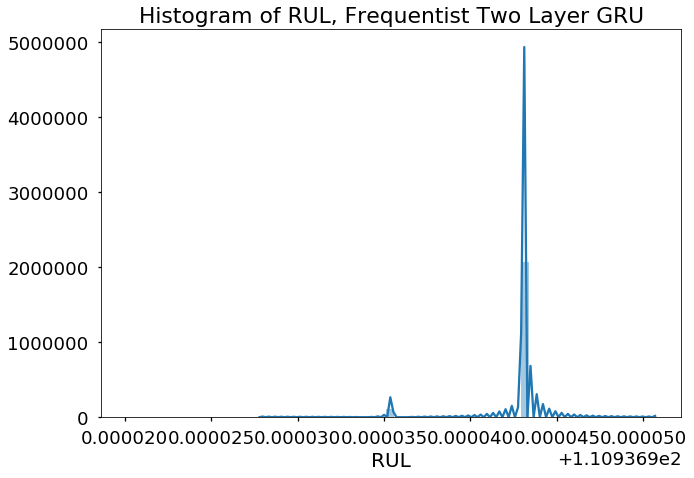

In [100]:
y_pred = np.squeeze(model.predict(seq_array2))
sns.distplot(y_pred)
plt.title('Histogram of RUL, Frequentist Two Layer GRU')
plt.xlabel('RUL');

In [101]:
print(f'Validation RMSE: {np.sqrt(mean_squared_error(label_array2,y_pred))}')

Validation RMSE: 67.9674301147461


In [102]:
print(f'Validation RMSE for RUL under 50: {np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50]))}')

Validation RMSE for RUL under 50: 87.18844604492188


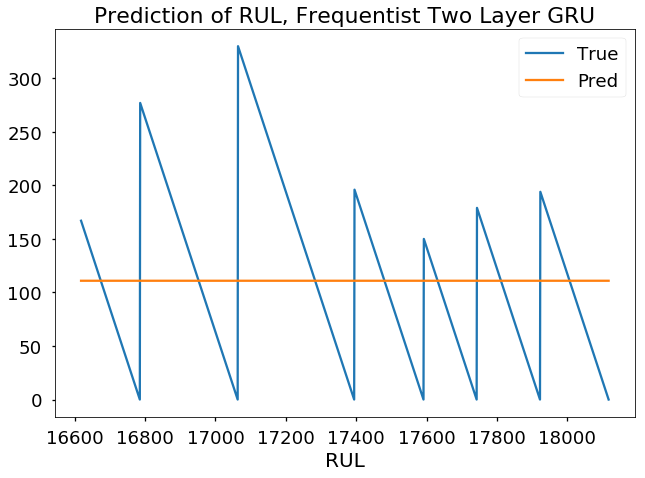

In [103]:
pd.DataFrame([label_array2,y_pred]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Frequentist Two Layer GRU')
plt.xlabel('RUL');

In [104]:
def two_GRU_layer(X, Wz1, Uz1, Wr1, Ur1, Wh1, Uh1, bz1, br1, bh1, 
              Wz2, Uz2, Wr2, Ur2, Wh2, Uh2, bz2, br2, bh2, Wy, by, H1,H2):
    N, sequence_length, D = X.get_shape().as_list()
    h1 = tf.zeros([N,H1])
    h2 = tf.zeros([N,H2])
    for i in range(sequence_length):
        h1 = GRU_cell(h1, tf.squeeze(tf.slice(X,[0,i,0],[N,1,D])), Wz1, Uz1, Wr1, Ur1, Wh1, Uh1, bz1, br1, bh1)
        h2 = GRU_cell(h2, h1, Wz2, Uz2, Wr2, Ur2, Wh2, Uh2, bz2, br2, bh2)
    return tf.reshape(tf.matmul(h2, Wy) + by,[-1])


Wz1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Uz1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))
Wr1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Ur1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))
Wh1 = Normal(loc=tf.zeros([H1, H1]), scale=tf.ones([H1, H1]))
Uh1 = Normal(loc=tf.zeros([D, H1]), scale=tf.ones([D, H1]))

Wz2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Uz2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))
Wr2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Ur2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))
Wh2 = Normal(loc=tf.zeros([H2, H2]), scale=tf.ones([H2, H2]))
Uh2 = Normal(loc=tf.zeros([H1, H2]), scale=tf.ones([H1, H2]))

Wy = Normal(loc=tf.zeros([H2, 1]), scale=tf.ones([H2, 1]))
bz1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
br1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bh1 = Normal(loc=tf.zeros(H1), scale=tf.ones(H1))
bz2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
br2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
bh2 = Normal(loc=tf.zeros(H2), scale=tf.ones(H2))
by = Normal(loc=tf.zeros(1), scale=tf.ones(1))

X = tf.placeholder(tf.float32,[N,sequence_length,D])
y = Normal(loc=two_GRU_layer(X, Wz1, Uz1, Wr1, Ur1, Wh1, Uh1, bz1, br1, bh1, 
              Wz2, Uz2, Wr2, Ur2, Wh2, Uh2, bz2, br2, bh2, Wy, by, H1,H2), scale=1.)

In [105]:
# BACKWARD MODEL A
q_Wz1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Uz1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))
q_Wr1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Ur1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))
q_Wh1 = Normal(loc=tf.Variable(tf.random_normal([H1, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H1]))))
q_Uh1 = Normal(loc=tf.Variable(tf.random_normal([D, H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, H1]))))

q_Wz2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Uz2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))
q_Wr2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Ur2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))
q_Wh2 = Normal(loc=tf.Variable(tf.random_normal([H2, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, H2]))))
q_Uh2 = Normal(loc=tf.Variable(tf.random_normal([H1, H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1, H2]))))

q_Wy = Normal(loc=tf.Variable(tf.random_normal([H2, 1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2, 1]))))
q_bz1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_br1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bh1 = Normal(loc=tf.Variable(tf.random_normal([H1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H1]))))
q_bz2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_br2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_bh2 = Normal(loc=tf.Variable(tf.random_normal([H2])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([H2]))))
q_by = Normal(loc=tf.Variable(tf.random_normal([1])),
               scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [106]:
# INFERENCE A
# this will take a couple of minutes
inference = ed.KLqp(latent_vars={Wz1: q_Wz1, Uz1: q_Uz1, Wr1: q_Wr1, Ur1: q_Ur1, Wh1: q_Wh1, Uh1: q_Uh1,
                                 Wz2: q_Wz2, Uz2: q_Uz2, Wr2: q_Wr2, Ur2: q_Ur2, Wh2: q_Wh2, Uh2: q_Uh2,
                                 bz1: q_bz1, bz1: q_bz1, bh1: q_bh1, 
                                 bz2: q_bz2, bz2: q_bz2, bh2: q_bh2, Wy: q_Wy, by: q_by},
                    data={X:seq_array1,y:label_array1})
inference.run(n_samples=5, n_iter=2500)

2500/2500 [100%] ██████████████████████████████ Elapsed: 1126s | Loss: 446700.375


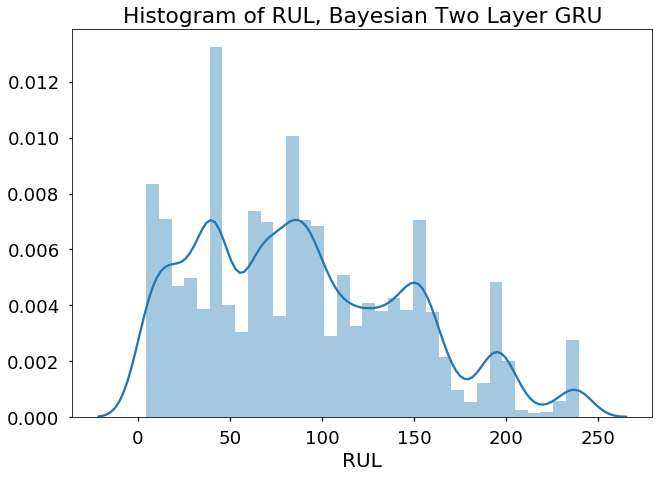

In [107]:
Xp = tf.placeholder(tf.float32,seq_array2.shape)
y_preds = [sess.run(two_GRU_layer(Xp, q_Wz1, q_Uz1, q_Wr1, q_Ur1, q_Wh1, q_Uh1, q_bz1, q_br1, q_bh1, 
              q_Wz2, q_Uz2, q_Wr2, q_Ur2, q_Wh2, q_Uh2, q_bz2, q_br2, q_bh2, q_Wy, q_by, H1, H2),
                    {Xp:seq_array2})
          for _ in range(50)]
sns.distplot(y_preds[0])
plt.title('Histogram of RUL, Bayesian Two Layer GRU')
plt.xlabel('RUL');

In [108]:
print(f'Average Validation RMSE: {np.mean([np.sqrt(mean_squared_error(label_array2,y_pred)) for y_pred in y_preds])}')

Average Validation RMSE: 44.27805709838867


In [109]:
print(f'Average Validation RMSE for RUL under 50: {np.mean([np.sqrt(mean_squared_error(label_array2[less_50],\
      y_pred[less_50])) for y_pred in y_preds])}')

Average Validation RMSE for RUL under 50: 11.107863426208496


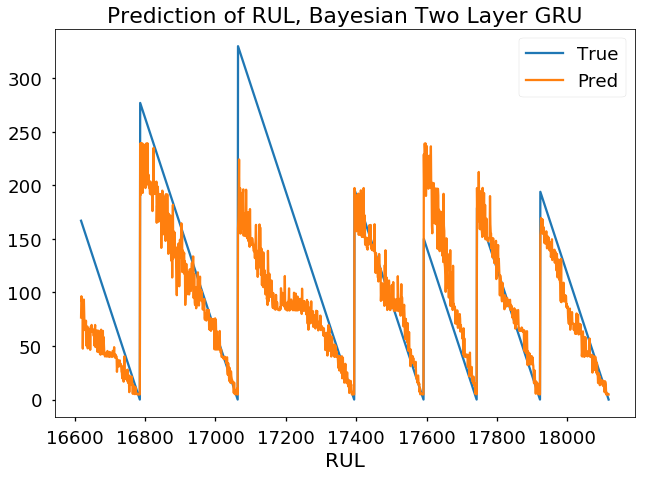

In [110]:
pd.DataFrame([label_array2,y_preds[0]]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of RUL, Bayesian Two Layer GRU')
plt.xlabel('RUL');

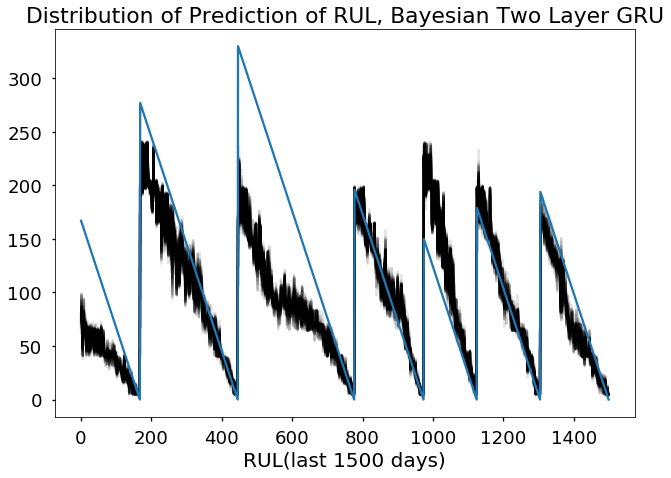

In [111]:
[plt.plot(y_pred[-1500:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-1500:])
plt.title('Distribution of Prediction of RUL, Bayesian Two Layer GRU')
plt.xlabel('RUL(last 1500 days)');

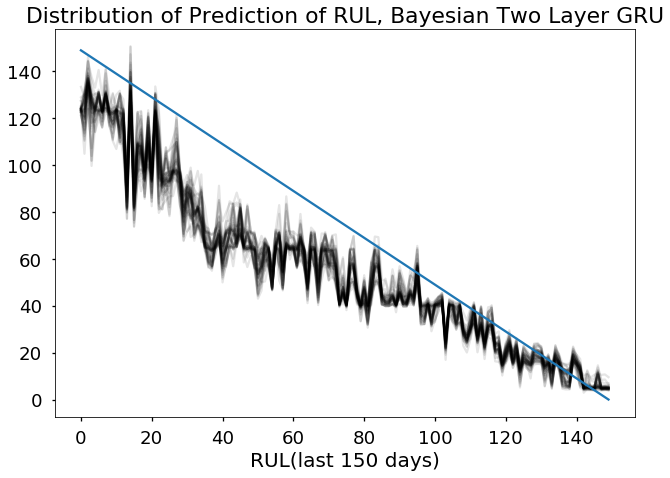

In [112]:
[plt.plot(y_pred[-150:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array2[-150:])
plt.title('Distribution of Prediction of RUL, Bayesian Two Layer GRU')
plt.xlabel('RUL(last 150 days)');

## Test Using the Best Model(LSTM)

In [14]:
# generator for the sequences
seq_gen_test = [list(gen_sequence(test_df[test_df['id']==id], sequence_length, sequence_cols)) 
           for id in test_df['id'].unique()]

In [15]:
# generate sequences and convert to numpy array
seq_array_test = np.concatenate(seq_gen_test).astype(np.float32)
seq_array_test.shape

(12596, 5, 25)

In [16]:
# generate labels
label_gen_test = [gen_labels(test_df[test_df['id']==id], sequence_length, ['RUL']) 
             for id in test_df['id'].unique()]
label_array_test = np.squeeze(np.concatenate(label_gen_test).astype(np.float32))
label_array_test.shape

(12596,)

In [18]:
less_50_test = label_array_test <= 50

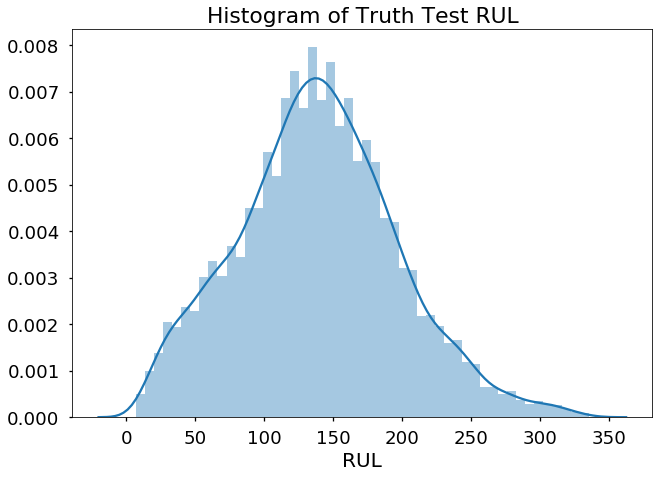

In [19]:
sns.distplot(label_array_test)
plt.title('Histogram of Truth Test RUL')
plt.xlabel('RUL');

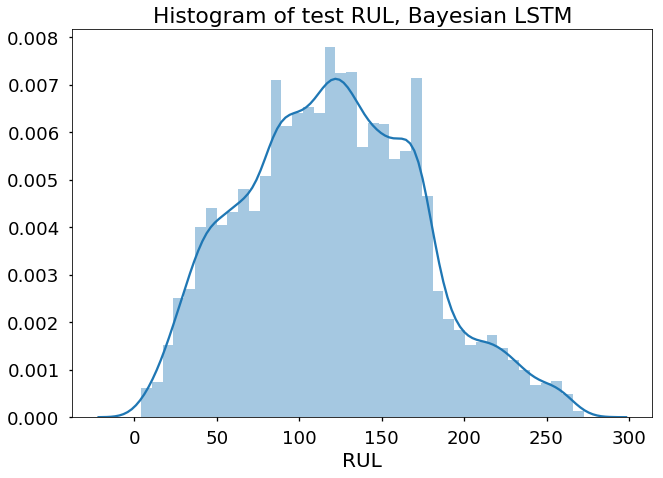

In [23]:
Xp = tf.placeholder(tf.float32,seq_array_test.shape)
y_preds = [sess.run(LSTM_layer(Xp, q_Wf, q_Uf, q_Wi, q_Ui, q_Wo, q_Uo, q_Wc, q_Uc, 
                             q_bf, q_bi, q_bo, q_bc, q_Wy, q_by, H),{Xp:seq_array_test})
          for _ in range(50)]
sns.distplot(y_preds[0])
plt.title('Histogram of Test RUL, Bayesian LSTM')
plt.xlabel('RUL');

In [25]:
print(f'Average Validation RMSE: {np.mean([np.sqrt(mean_squared_error(label_array_test,y_pred)) for y_pred in y_preds])}')

Average Validation RMSE: 49.27251434326172


In [28]:
print(f'Average Validation RMSE for RUL under 50: {np.mean([np.sqrt(mean_squared_error(label_array_test[less_50_test],\
      y_pred[less_50_test])) for y_pred in y_preds])}')

Average Validation RMSE for RUL under 50: 17.32678985595703


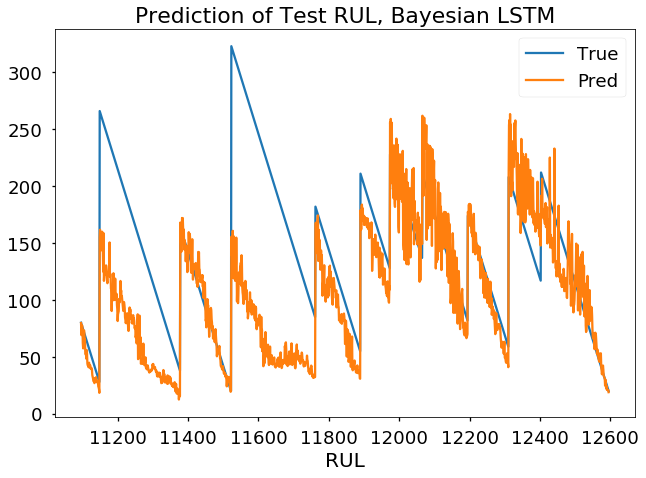

In [29]:
pd.DataFrame([label_array_test,y_preds[0]]).transpose().rename(columns={0:'True',1:'Pred'})[-1500:].plot()
plt.title('Prediction of Test RUL, Bayesian LSTM')
plt.xlabel('RUL');

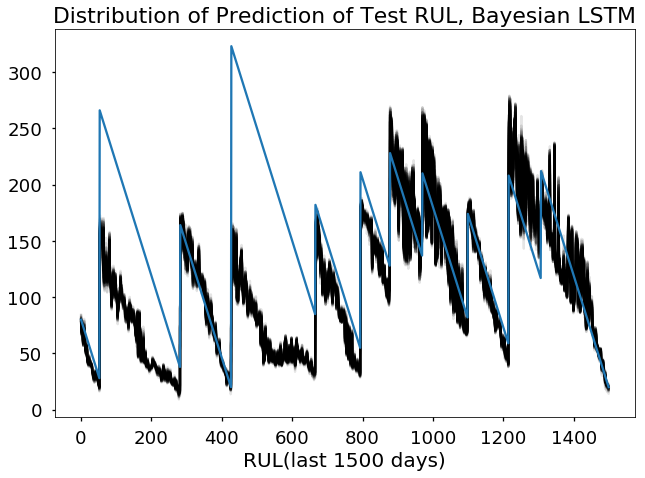

In [34]:
[plt.plot(y_pred[-1500:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array_test[-1500:])
plt.title('Distribution of Prediction of Test RUL, Bayesian LSTM')
plt.xlabel('RUL(last 1500 days)');

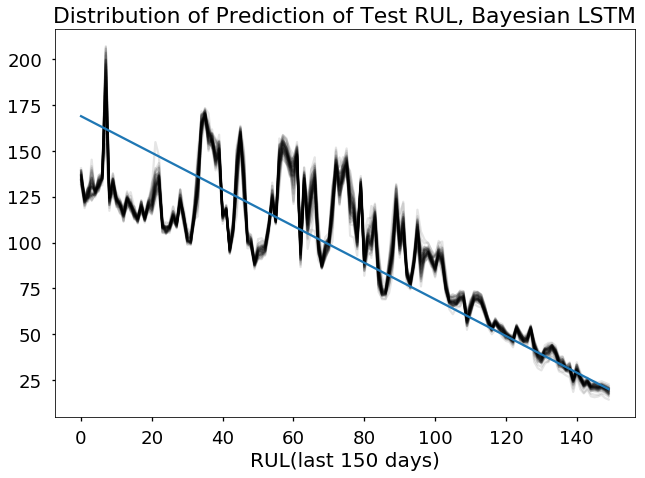

In [35]:
[plt.plot(y_pred[-150:], color='black', alpha=0.1) for y_pred in y_preds]
plt.plot(label_array_test[-150:])
plt.title('Distribution of Prediction of Test RUL, Bayesian LSTM')
plt.xlabel('RUL(last 150 days)');